In [76]:
import nltk
#nltk.download('stopwords')
#nltk.download('wordnet')
from sagemaker.tensorflow import TensorFlow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
import unicodedata
from sklearn.metrics import classification_report,accuracy_score,precision_score,precision_recall_fscore_support

In [2]:
import boto3
s3=boto3.resource("s3")

embeded_index = dict()

import s3fs
fs = s3fs.S3FileSystem()

# To List 5 files in your accessible bucket
fs.ls('s3://glove-bucket/glove.6B.300d.txt')

# open it directly
i=0
with fs.open(f's3://glove-bucket/glove.6B.300d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeff = np.asarray(values[1:],dtype="float32")
        embeded_index[word] = coeff
        i+=1
       # print(i,end =" ")
f.close()
#print("hello")
        
            
    #display(Image.open(f))
# import pandas as pd

# bucket='glove-bucket'
# data_key = 'glove.6B.300d.txt'
# # bucket='purvisbcuket3'
# # data_key = 'cancer.csv'
# data_location = 's3://{}/{}'.format(bucket, data_key)


# f=open(data_location)
# pd.read_csv(data_location)

KeyboardInterrupt: 

In [43]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping,ModelCheckpoint
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from sklearn.manifold import TSNE
from keras.layers import LSTM


In [44]:
review = pd.read_csv("new_dataset_indian_resto_review.csv")

In [4]:
review.iloc[4]

Unnamed: 0                                                     4
business_id                               H_YBTOS23PRhrjWtP7TeJw
name                                      Marigold Indian Bistro
categories                        Indian, Pakistani, Restaurants
useful                                                         3
text           My family loves Indian food and we have been e...
stars                                                          5
funny                                                          0
cool                                                           0
Name: 4, dtype: object

In [45]:
def find_useful(df):
#     if (df["useful"] == 0) & (df["funny"] == 0) & (df["cool"] == 0):
#         return 0
#     else:
#         return 1
    
    #print(df[4],df[7],df[8])
    if df[6] <= 2: # and df[7]==0 and df[8] ==0:
        return 0
    else:
        return 1
        
#         return df[4]
#     else:
#         return 1
    


In [46]:
review["label"] = review.apply(find_useful,axis=1)

In [47]:
review.head(2)

,Unnamed: 0,business_id,name,categories,useful,text,stars,funny,cool,label
0,0,iE71iwcSljg3xm2GB2Y9aA,Marigold Maison- Paradise Valley,"Indian, Restaurants",0,I have been here several times since my last u...,5.0,0,0,1
1,1,DJuQgsoj-qmU0i5iTAa4aA,Tadka Restaurant,"Restaurants, Indian",0,We just tried to eat here and I'm pretty sure ...,1.0,1,0,0


In [48]:
review = review[["text","label"]]

In [49]:
review = review.dropna()
review.head(5)
review["label"].value_counts()

1    63567
0    16225
Name: label, dtype: int64

In [50]:
review.head(2)

,text,label
0,I have been here several times since my last u...,1
1,We just tried to eat here and I'm pretty sure ...,0


In [19]:
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii.decode()
stopwords_ = set(stopwords.words("english"))
lemmatizer=WordNetLemmatizer()

In [20]:
def pre_processing(india_review):
    india_review["normalizes_text"] = india_review["text"].apply(lambda x:remove_accents(x))
    #india_review["remove_html"] = india_review['normalizes_text'].apply(lambda x: strip_html_tags(x))
    india_review["remove_special"] = india_review["normalizes_text"].replace(r'[^A-Za-z0-9 ]+', '', regex=True)
    
    india_review["token_text"] = india_review["remove_special"].apply(lambda x:[word.lower() for word in x.split(" ")]) 
    #india_review["token_text"] = india_review["token_text"].apply(lambda x:[word for word in x if word not in common_words_list])
    
    india_review["remove_stop"] = india_review["token_text"].apply(lambda x:[word for word in x if word not  in stopwords_])
    india_review["lemitize_text"] = india_review["remove_stop"].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x]))
 #   india_review["length"] = india_review["remove_stop"].apply(lambda x:find_length(x))
   # review["clean_list"] = review["lemitize_text"].apply(lambda x:[word for word in x.split(" ")])
#    india_review["texts_to_sequences"] = india_review["lemitize_text"].apply(lambda x:)

    return india_review    

In [51]:
review = review.sample(frac=0.80, random_state=0)

In [52]:
#review=pre_processing(review)

In [53]:
#review["lemitize_text"]
train_set = review.sample(frac=0.90, random_state=0)
test_set = review.drop(train_set.index)

In [54]:
# # train_review = train_set["lemitize_text"]
# # test_review = test_set["lemitize_text"]
# # train_review.head()
# # label_train = train_set["label"]
# label_test = test_set["label"]



In [55]:
from sklearn.model_selection import train_test_split

In [56]:
#type(train_review)

In [57]:
from keras.layers import Dense, LSTM


In [58]:
#train_review.head(5)

In [59]:
def token_sequence(review):
    max_len=50
    embed_dim=100
    max_words=5000
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(review["text"])
    sequences = tokenizer.texts_to_sequences(review["text"])
    data = pad_sequences(sequences,maxlen=max_len,padding='post')
    return tokenizer,data
    print(data)

In [60]:
#tokenizer_train,train_data=token_sequence(train_set)

In [19]:

#tokenizer_test,test_data=token_sequence(test_set)

In [61]:
def create_label_array(review):
    return np.asarray(review["label"])

In [62]:
train_labels = create_label_array(train_set) #validation test
test_labels = create_label_array(test_set) # unseen test

In [63]:
X_train, X_test, y_train, y_test = train_test_split(train_set, train_labels, test_size=0.20, random_state=42)

In [64]:
tokenizer_train,train_data=token_sequence(X_train)
tokenizer_val_test,val_data=token_sequence(X_test)

In [65]:
tokenizer_final_test,finaltest_data=token_sequence(test_set)

In [66]:
max_len=50
embed_dim=100
max_words=5000
embeded_matrix = np.zeros((max_words,embed_dim))

In [35]:
# for word, i in tokenizer_train.word_index.items():
#     if i < max_words:
#         embed_vector = embeded_index.get(word)
#         if embed_vector is not None:
#             embed_matrix[i] = embed_vector

In [67]:
model = Sequential()
#model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
#model.add(SpatialDropout1D(0.2))
model.add(Embedding(max_words,embed_dim,input_length=50))#max_len)) #weights = [embeded_matrix]
#model.add(Dropout(0.3))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))


In [68]:
#model.add(Flatten())
# model.add(Dropout(0.5))
# model.add(Dense(32,activation="relu"))
# model.add(Dropout(0.5))
model.add(Dense(1,activation="sigmoid"))


In [69]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 100)           500000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 50, 100)           80400     
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 660,901
Trainable params: 660,901
Non-trainable params: 0
_________________________________________________________________


In [70]:
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

In [71]:
early_stoping = EarlyStopping(monitor="val_loss",patience=5,mode=min)
save_best = ModelCheckpoint("yelpcomments_model.hdf",save_best_only=True,monitor = "val_loss",mode="min")

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/callbacks.py:511: RuntimeWarning: EarlyStopping mode <built-in function min> is unknown, fallback to auto mode.
  RuntimeWarning)


In [72]:
%%time
model.fit(train_data,y_train,epochs=10,validation_data=(val_data,y_test),batch_size=128,verbose=1,callbacks=[early_stoping])

Train on 45960 samples, validate on 11491 samples
Epoch 1/10
45960/45960 [==============================] - 210s 5ms/step - loss: 0.3058 - acc: 0.8732 - val_loss: 0.6622 - val_acc: 0.7267
Epoch 2/10
45960/45960 [==============================] - 201s 4ms/step - loss: 0.2147 - acc: 0.9114 - val_loss: 0.6308 - val_acc: 0.7530
Epoch 3/10
45960/45960 [==============================] - 201s 4ms/step - loss: 0.1956 - acc: 0.9206 - val_loss: 0.6934 - val_acc: 0.7456
Epoch 4/10
45960/45960 [==============================] - 201s 4ms/step - loss: 0.1733 - acc: 0.9316 - val_loss: 0.8721 - val_acc: 0.7570
Epoch 5/10
45960/45960 [==============================] - 200s 4ms/step - loss: 0.1573 - acc: 0.9375 - val_loss: 0.9715 - val_acc: 0.7596
Epoch 6/10
45960/45960 [==============================] - 200s 4ms/step - loss: 0.1409 - acc: 0.9444 - val_loss: 0.8546 - val_acc: 0.7346
Epoch 7/10
45960/45960 [==============================] - 200s 4ms/step - loss: 0.1249 - acc: 0.9527 - val_loss: 0.9318 - 

In [73]:
#len(train_data)
#model.fit(train_data,y_train,epochs=3,validation_data=(finaltest_data,test_labels),batch_size=128,verbose=1,callbacks=[early_stoping])

Train on 45960 samples, validate on 6383 samples
Epoch 1/3
45960/45960 [==============================] - 200s 4ms/step - loss: 0.1124 - acc: 0.9574 - val_loss: 0.8008 - val_acc: 0.7496
Epoch 2/3
45960/45960 [==============================] - 200s 4ms/step - loss: 0.0993 - acc: 0.9636 - val_loss: 1.0290 - val_acc: 0.7257
Epoch 3/3
45960/45960 [==============================] - 200s 4ms/step - loss: 0.0919 - acc: 0.9661 - val_loss: 1.0345 - val_acc: 0.7392


In [88]:
score = model.evaluate(finaltest_data, test_labels, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

y_pred = model.predict(finaltest_data)
y_pred_labels = (y_pred > 0.5).astype(np.int)



Test score: 1.0345285842546788
Test accuracy: 0.7391508695251158


In [74]:
prediction = model.predict(finaltest_data)

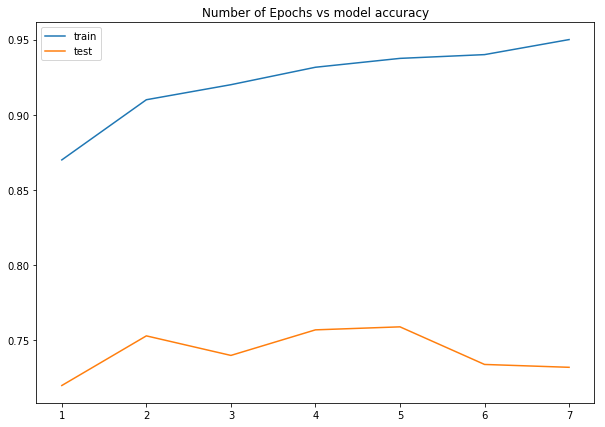

In [98]:
train_accuracy = np.array([0.87,0.91,0.92,0.9316,0.9375,0.94,0.95])
test_accuracy = np.array([0.72,0.753,0.74,0.757,0.759,0.734,0.7321])
epocs = np.array([1,2,3,4,5,6,7])
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(epocs,train_accuracy,label="train")
plt.plot(epocs,test_accuracy,label="test")
plt.title("Number of Epochs vs model accuracy")
plt.legend()
plt.savefig("fig/accuracy_lstm")

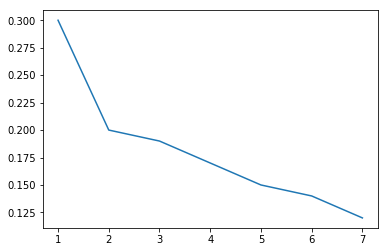

In [84]:
import matplotlib.pyplot as plt
train_loss = np.array([0.3,0.2,0.19,0.17,0.15,0.14,0.12])
test_loss = np.array([0.66,0.63,0.69,0.17,0.15,0.14,0.12])
epocs = np.array([1,2,3,4,5,6,7])
plt.plot(epocs,train_loss)

In [78]:
print(prediction)
#accuracy_score(prediction,test_labels)

[[0.98782825]
 [0.98985016]
 [0.9994304 ]
 ...
 [0.9998498 ]
 [0.9962578 ]
 [0.9916311 ]]


In [62]:
len(finaltest_data)

NameError: name 'test_data' is not defined

In [24]:
print(train_data.shape)
print(train_labels.shape)

(59844, 50)
(59844,)


In [25]:
vocab_size_train = len(tokenizer_train.word_index)+1
vocab_size_train

91991

In [26]:
vocab_size_test = len(tokenizer_test.word_index)+1
vocab_size_test

45339

In [27]:
validation_split=0.2
indices = np.arange(train_data.shape[0])

In [28]:
np.random.shuffle(indices)

In [29]:
train_data = train_data[indices]
train_labels = train_labels[indices]

In [30]:
val_samples = int(validation_split*train_data.shape[0])

In [31]:
X_train = train_data[0:-val_samples]
y_train = train_labels[0:-val_samples]
x_val = train_data[-val_samples:]
y_val = train_labels[-val_samples:]

In [34]:
tokenizer_train.word_index.items()

dict_items([('food', 1), ('indian', 2), ('place', 3), ('good', 4), ('chicken', 5), ('restaurant', 6), ('service', 7), ('great', 8), ('time', 9), ('like', 10), ('dish', 11), ('buffet', 12), ('one', 13), ('naan', 14), ('really', 15), ('would', 16), ('go', 17), ('back', 18), ('get', 19), ('ordered', 20), ('order', 21), ('also', 22), ('lunch', 23), ('best', 24), ('curry', 25), ('delicious', 26), ('rice', 27), ('try', 28), ('u', 29), ('nice', 30), ('masala', 31), ('ive', 32), ('dont', 33), ('well', 34), ('menu', 35), ('price', 36), ('come', 37), ('spicy', 38), ('even', 39), ('definitely', 40), ('came', 41), ('little', 42), ('got', 43), ('im', 44), ('love', 45), ('taste', 46), ('always', 47), ('staff', 48), ('make', 49), ('sauce', 50), ('butter', 51), ('first', 52), ('went', 53), ('much', 54), ('table', 55), ('friendly', 56), ('didnt', 57), ('take', 58), ('tikka', 59), ('amazing', 60), ('fresh', 61), ('eat', 62), ('spice', 63), ('dinner', 64), ('never', 65), ('meal', 66), ('lamb', 67), ('thi

In [32]:
embed_index = 

SyntaxError: invalid syntax (<ipython-input-32-fa3f4700dae0>, line 1)

dict_items([('food', 1), ('indian', 2), ('place', 3), ('good', 4), ('chicken', 5), ('restaurant', 6), ('service', 7), ('great', 8), ('time', 9), ('like', 10), ('dish', 11), ('buffet', 12), ('one', 13), ('naan', 14), ('really', 15), ('would', 16), ('go', 17), ('back', 18), ('get', 19), ('ordered', 20), ('order', 21), ('also', 22), ('lunch', 23), ('best', 24), ('curry', 25), ('delicious', 26), ('rice', 27), ('try', 28), ('u', 29), ('nice', 30), ('masala', 31), ('ive', 32), ('dont', 33), ('well', 34), ('menu', 35), ('price', 36), ('come', 37), ('spicy', 38), ('even', 39), ('definitely', 40), ('came', 41), ('little', 42), ('got', 43), ('im', 44), ('love', 45), ('taste', 46), ('always', 47), ('staff', 48), ('make', 49), ('sauce', 50), ('butter', 51), ('first', 52), ('went', 53), ('much', 54), ('table', 55), ('friendly', 56), ('didnt', 57), ('take', 58), ('tikka', 59), ('amazing', 60), ('fresh', 61), ('eat', 62), ('spice', 63), ('dinner', 64), ('never', 65), ('meal', 66), ('lamb', 67), ('thi